# Multi-planetary search

In this notebook, we use `nuance` to search for the transiting exoplanets with the following parameters:

In [63]:
truth = [
    {"t0":0.5, "D":0.03, "P":1.8, "depth":3e-3},
    {"t0":0.2, "D":0.03, "P":0.7, "depth":1e-3}
]

where $t_0$ is the transit epoch, $D$ its duration and $P$ its period (all in days). Let generate this signal together with correlated noise

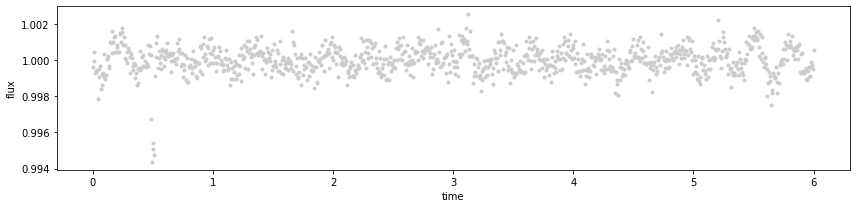

In [76]:
import jax
jax.config.update("jax_enable_x64", True)

import tinygp
import numpy as np
import matplotlib.pyplot as plt
from nuance.utils import periodic_transit

# measurements
time = np.linspace(0, 6, 1000)
error = 0.0005

transits = [p["depth"]*periodic_transit(time, p["t0"], p["D"], p["P"]) for p in truth]
mean = np.sum(transits, 0) + 1.

# GP
kernel = tinygp.kernels.quasisep.SHO(np.pi/(truth[1]["D"]*5), 8., truth[1]["depth"]/2)
gp = tinygp.GaussianProcess(kernel, time, diag=error**2, mean_value=mean)
flux = gp.sample(jax.random.PRNGKey(40))

plt.figure(None, (12, 3))
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()

## The *linear search*

We start by instantiating a [Nuance](nuance.Nuance) object, and perform the *linear search* over all times (considered as potential transit epochs) and on a wide range of durations.

In [65]:
from nuance import Nuance, utils

nu = Nuance(time, flux, error, kernel)

t0s = time.copy()
Ds = np.linspace(0.01, 0.2, 15)
nu.linear_search(t0s, Ds)

  0%|          | 0/1000 [00:00<?, ?it/s]

```{note}
Notice how we reused the same kernel used to generate the data. In practice, a kernel need to be properly set and its hyper-parameters optimized. See the [GP optimization tutorial](gp.ipynb)
```

Whatever the number of planets we will look for, this step needs to be done only once.

## The *periodic search*
### First planet

We can now perform the periodic search and plot the SNR periodogram

  0%|          | 0/4000 [00:00<?, ?it/s]

epoch: 0.498
duration: 0.024
period: 1.801


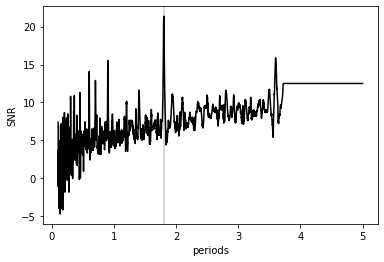

In [66]:
periods = np.linspace(0.1, 5, 4000)
search = nu.periodic_search(periods)

t0, D, P = search.best
plt.plot(search.periods, search.Q_snr, c="k")

plt.axvline(P, c="k", alpha=0.2)
plt.xlabel("periods"); plt.ylabel("SNR")

print("\n".join([f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration", "period"], [t0, D, P])]))

It seems we have a candidate, let see the corresponding phase folded signal

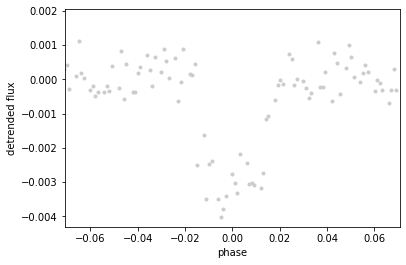

In [67]:
linear, astro, noise = nu.models(t0, D, P)
phi = utils.phase(time, t0, P)

plt.plot(phi, flux-(linear+noise), ".", c="0.8")
plt.xlabel("phase"); plt.ylabel("detrended flux")
_ = plt.xlim(-3*D, 3*D)

corresponding indeed to what we injected as a first planet

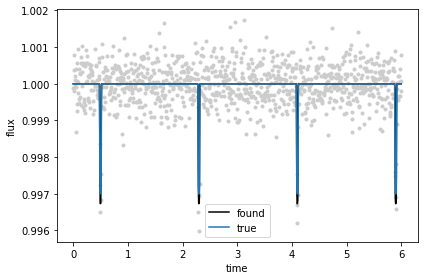

In [68]:
plt.plot(time, flux-noise, ".", c="0.8")
plt.plot(time, astro + 1., c="k", label="found")
plt.plot(time, transits[0] + 1., c="C0", label="true")
plt.legend()
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()

### Second search

To look for a second planetary candidate, we can mask the current candidate with

In [69]:
nu2 = nu.mask(*search.best)

and perform the second *periodic search*

```{note}
Again, we only have to perform another *periodic search*, reusing the products of the *linear search* without loss of sensitivity
``` 

  0%|          | 0/4000 [00:00<?, ?it/s]

epoch: 0.202
duration: 0.024
period: 0.700


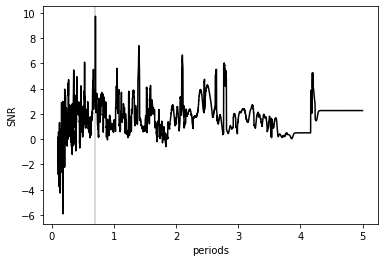

In [70]:
search2 = nu2.periodic_search(periods)

t0, D, P = search2.best
plt.plot(search2.periods, search2.Q_snr, c="k")

plt.axvline(P, c="k", alpha=0.2)
plt.xlabel("periods"); plt.ylabel("SNR")

print("\n".join([f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration", "period"], [t0, D, P])]))

And here is the second planet

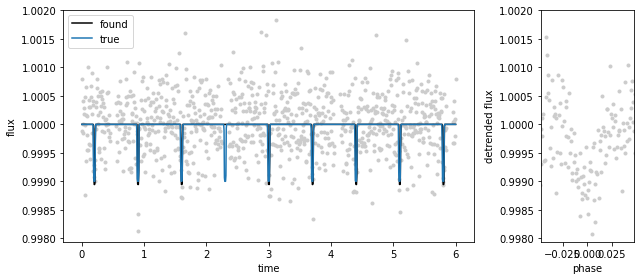

In [74]:
linear, astro, noise = nu2.models(t0, D, P)
phi = utils.phase(nu2.time, t0, P)

plt.figure(figsize=(9., 4.))

plt.subplot(1,4,(1, 3))
plt.plot(nu2.time, nu2.flux-noise, ".", c="0.8")
plt.plot(nu2.time, astro + 1., c="k", label="found")
plt.plot(time, transits[1] + 1., c="C0", label="true")
plt.legend()
plt.ylabel("flux")
plt.xlabel("time")
ylim = plt.ylim()

plt.subplot(1,4,4)
plt.plot(phi, nu2.flux-(linear+noise) + 1., ".", c="0.8")
plt.xlabel("phase"); plt.ylabel("detrended flux")
plt.xlim(-2*D, 2*D)
plt.ylim(ylim)


plt.tight_layout()

```{note}
Notice how we use `nu2` in the last cell, where previous transits are clearly masked from `nu2.flux`. By masking the first planet, we also mask the likelihoods values matching its parameters. This is how multiple searches can be performed without re-running the *linear search*
```